<a href="https://colab.research.google.com/github/toyo97/rgbd-domain-adaptation/blob/master/RGB_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GABRIELE

**Reading data**

In [14]:
from google.colab import drive
drive.mount("/content/drive/")
root = ("drive/My Drive/RGB Project/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!unzip -q "drive/My Drive/MLDL2020/ROD.zip" -d "RGB Project/"

In [0]:
!unzip -q "drive/My Drive/MLDL2020/synROD.zip" -d "RGB Project/"

In [0]:
from torchvision.datasets import VisionDataset

from PIL import Image

import os
import os.path
import sys


def pil_loader(path):

    with open(path, 'rb') as f:

        img = Image.open(f)
        return img.convert('RGB')


class ROD(VisionDataset):
  
    def __init__(self, root, transform=None, target_transform=None):
        super(ROD, self).__init__(root, transform=transform, target_transform=target_transform)

        self.images=[]
        self.categories={}


        numCat = -1
        RGB_folder = os.path.join(root,"ROD","ROD_rgb")
        depth_folder = os.path.join(root,"ROD","ROD_surfnorm")
        for class_object in sorted(os.listdir(RGB_folder)):
          path = os.path.join(RGB_folder, class_object)
          if os.path.isdir(path):
            numCat+=1
            for subfolder in os.listdir(path):
              subpath = os.path.join(path, subfolder)
              if os.path.isdir(subpath):
                rgb_path = os.path.join(subpath, "*.png")
                root_depth_path = os.path.join(depth_folder, class_object, subfolder)
                for image_rgb in glob.glob(rgb_path):
                  image_name = "_".join(image_rgb.split("/")[-1].split("_")[:-1]) + "_depthcrop.png"
                  image_depth = os.path.join(root_depth_path, image_name)
                  if os.path.isfile(image_depth):
                    display(image_depth)
                    self.images.append(((pil_loader(image_rgb), pil_loader(image_depth)), numCat))

          

    def __getitem__(self, index):

        images, label = self.images[index] 

        if self.transform is not None:

            image1 = self.transform(images[0])
            image2 = self.transform(images[1])

        return (image1,image2), label

    def __len__(self):

        length = len(self.images) 

        return length

In [0]:
class synROD(VisionDataset):
  
    def __init__(self, root, transform=None, target_transform=None):
        super(ROD, self).__init__(root, transform=transform, target_transform=target_transform)


        self.images=[]
        self.categories={}

        numCat = -1
        for class_object in sorted(os.listdir(os.path.join(root,"synROD"))):
          path = os.path.join(root,"synROD", class_object)
          if os.path.isdir(path):
            numCat+=1
            rgb_path = os.path.join(path, "rgb", "*.png")
            root_depth_path = os.path.join(path, "depth")
            for image_rgb in glob.glob(rgb_path):
              image_depth = os.path.join(root_depth_path, image_rgb.split("/")[-1])
              if os.path.isfile(image_depth):
                self.images.append(((pil_loader(image_rgb), pil_loader(image_depth)), numCat))

          

    def __getitem__(self, index):

        images, label = self.images[index] 

        if self.transform is not None:

            image1 = self.transform(images[0])
            image2 = self.transform(images[1])

        return (image1,image2), label

    def __len__(self):

        length = len(self.images) 

        return length

In [5]:
source_dataset = synROD("RGB Project", transform=?)
target_dataset = ROD("RGB Project", transform=?)

0


#VITTORIO

In [0]:
!find "/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/" -iname *56_crop.png | head -5

/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/rubber_eraser/rubber_eraser_3/rubber_eraser_3_4_256_crop.png
/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/rubber_eraser/rubber_eraser_3/rubber_eraser_3_4_56_crop.png
/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/toothbrush/toothbrush_1/toothbrush_1_2_156_crop.png
/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/toothbrush/toothbrush_1/toothbrush_1_1_156_crop.png
/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/toothbrush/toothbrush_1/toothbrush_1_1_56_crop.png


## Rotation transformation

Source: https://pytorch.org/docs/stable/torchvision/transforms.html

In [0]:
import torch

a = torch.empty((30, 3, 32, 32))
a.size()

torch.Size([30, 3, 32, 32])

In [0]:
for i in range(a.size()[0]):
  a[i,:,:,:] = torch.randn((3,32,32))

In [0]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        new_tensor = torch.empty(tensor.size())
        for i, t, m, s in zip(range(3), tensor, self.mean, self.std):
            new_tensor[i,:,:] = t.mul(s).add(m)

        return new_tensor

In [0]:
import torch
import torchvision.transforms.functional as TF
from torchvision import transforms
import random
import numpy as np

def transform_batch(rgb_batch, depth_batch):
  """
  params: both rgb_batch and depth_batch are tensors of shape (BATCH_SIZE, 3, 224, 224)
  """

    # F: from normalized tensor, to unnormalized PIL image
  F = transforms.Compose([
                            UnNormalize(imgnet_mean, imgnet_std),
                            transforms.ToPILImage()
  ])
    # G: inverseF
  G = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(imgnet_mean, imgnet_std)
  ])

  # New batches with rotation labels
  new_rgb_batch = torch.empty(rgb_batch.size())
  new_depth_batch = torch.empty(depth_batch.size())
  labels = torch.empty(rgb_batch.size()[0], dtype=torch.int)

  for i in range(rgb_batch.size()[0]):
    # denormalize and back to PIL image
    rotated_images, labels[i] = coupled_rotation((F(rgb_batch[i,:,:,:]), F(depth_batch[i,:,:,:])))
    new_rgb_batch[i,:,:,:], new_depth_batch[i,:,:,:] = G(rotated_images[0]), G(rotated_images[1])

  return new_rgb_batch, new_depth_batch, labels
  


def coupled_rotation(image_tuple):

  # FIXME one-hot-encoding not necessary. Using int labels [0,3] instead
  def one_hot(n):
    oen = torch.zeros(4)
    oen[n] = 1
    return oen

  j = random.randint(0,3)
  k = random.randint(0,3)

  z = (k-j) % 4

  # Note: TF.rotate is counter-clockwise
  rotated_image_tuple = TF.rotate(image_tuple[0], 270*j), TF.rotate(image_tuple[1], 270*k)

  return rotated_image_tuple, z

**TEST**

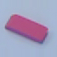

In [0]:
img_path_a = '/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/rubber_eraser/rubber_eraser_3/rubber_eraser_3_4_56_crop.png'
a = Image.open(img_path_a).convert('RGB')

display(a)

In [0]:
img_tensor = train_transform(a)
img_batch = img_tensor.unsqueeze(0)
img_batch.size()

torch.Size([1, 3, 224, 224])

In [0]:
rgb_batch, depth_batch, labels = transform_batch(img_batch, img_batch)

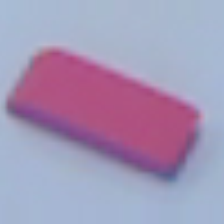

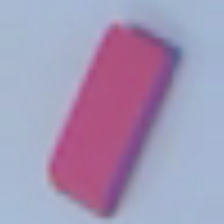

"How many times should the first image be rotated by 90 degrees clockwise to align with the second?"
3 time(s), i.e. relative rotation of 270 degrees


In [0]:
F = transforms.Compose([
                            UnNormalize(imgnet_mean, imgnet_std),
                            transforms.ToPILImage()
  ])

display(F(rgb_batch.squeeze()))
display(F(depth_batch.squeeze()))
z = labels[0]
print('"How many times should the first image be rotated by 90 degrees clockwise to align with the second?"')
print(f'{z} time(s), i.e. relative rotation of {z * 90} degrees')

**Imports**

In [0]:
import torch
import torchvision
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Subset, DataLoader
from torch.utils.data.dataset import random_split
from torch.backends import cudnn

**Hyperparameters**

In [0]:
DEVICE = 'cuda'      # 'cuda' or 'cpu'

LR = 10e-3
MOMENTUM = 0.9
STEP_SIZE = 10
GAMMA = 0.1
# TODO see if batch size should be different for main and pretext
BATCH_SIZE = 100

LAMBDA = 0.1 # weights contribution of the pretext loss to the total objective

imgnet_mean, imgnet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

**Define Data Processing**

In [0]:
train_transform = transforms.Compose([ transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),                                     
                                      transforms.Normalize( mean=imgnet_mean, # ImageNet mean and std
                                                            std=imgnet_std)]
)

val_transform = transforms.Compose([ transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize( mean=imgnet_mean, # ImageNet mean and std
                                                          std=imgnet_std)]
)

**Prepare DataLoaders**

In [0]:
# Data loaders for synROD (train and validation) - MAIN task
# ASK validation needed?
source_train_dataloader_m = DataLoader(source_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
source_val_dataloader_m = DataLoader(source_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Data loaders for synROD (train and validation) - PRETEXT task
source_train_dataloader_p = DataLoader(source_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
source_val_dataloader_p = DataLoader(source_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Data loader for ROD train - PRETEXT task only
target_train_dataloader = DataLoader(target_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

# Data loader for ROD validation - MAIN task only
target_val_dataloader = DataLoader(target_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
target_test_dataloader = DataLoader(target_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**



In [0]:
net = Net()

**Prepare Training**

In [0]:
class MultipleOptimizer(object):
    def __init__(*op):
        self.optimizers = op

    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()

In [0]:
# Define loss
# Both main and pretext losses are computed with the cross entropy function
criterion = nn.CrossEntropyLoss()

# Define optimizer
# TODO try with different optimizers for the three components of the network
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM)

# Define scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
# Define the number of iterations

NUM_ITER = min(len(source_train_dataset), len(target_train_dataset)) // BATCH_SIZE

**Training**

In [0]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

for epoch in range(2):  # loop over the dataset multiple times

  running_loss_m = 0.0
  running_loss_p = 0.0
  
  source_data_iter_m = iter(source_train_dataloader_m)
  source_data_iter_p = iter(source_train_dataloader_p)
  target_data_iter = iter(target_train_dataloader)

  for it in range(NUM_ITER):

    # set to train and zero the parameter gradients
    net.train()
    optimizer.zero_grad()

    # ************************
    # SOURCE MAIN FORWARD PASS
    # ************************
    images, labels = source_data_iter_m.next()

    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # forward
    outputs = net(images, 'main')
    # compute main loss
    loss_m = criterion(outputs, labels)

    # ***************************
    # SOURCE PRETEXT FORWARD PASS
    # ***************************
    source_images, source_labels = transform_batch(source_data_iter_p.next())

    # Bring data over the device of choice
    source_images = source_images.to(DEVICE)
    source_labels = source_labels.to(DEVICE)

    # forward
    source_outputs = net(source_images, 'pretext')

    # ***************************
    # TARGET PRETEXT FORWARD PASS
    # ***************************
    target_images, target_labels = transform_batch(target_data_iter.next())

    # Bring data over the device of choice
    target_images = target_images.to(DEVICE)
    target_labels = target_labels.to(DEVICE)

    # forward
    target_outputs = net(target_images, 'pretext')

    # compute pretext loss
    # check if more efficient when backward done separately
    # source: https://stackoverflow.com/questions/53994625/how-can-i-process-multi-loss-in-pytorch
    loss_p = LAMBDA * (criterion(source_outputs, source_labels) + criterion(target_outputs, target_labels))
    loss_m.backward()
    loss_p.backward()

    optimizer.step()

    # print statistics
    running_loss_m += loss_m.item()
    running_loss_p += loss_p.item()
    if i % 100 == 99:    # print every 100 mini-batches
      print('[%d, %5d] loss main: %.3f' % (epoch + 1, i + 1, running_loss_m / 100, running_loss_p / (LAMBDA * 100)))
      running_loss_m = 0.0
      running_loss_p = 0.0

  scheduler.step()

print('Finished Training')

#EMANUELE

In [0]:
from torchvision import models
import torch
import torch.nn as nn

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.resnet18 = models.resnet18(pretrained=True)
    self.depthFeatureExtractor = nn.Sequential(*(list(self.resnet18.children())[:-2])) # Eliminate last fc and avg pool
    self.rgbFeatureExtractor = nn.Sequential(*(list(self.resnet18.children())[:-2])) # Eliminate last fc and avg pool
    
    self.mainHead = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), # output has shape (batch_size, num_featues, 1, 1)
        nn.Linear(512 , 1000),        # wants first dimension = batch_size
                                      # In resnet18 it is 512 * block.expansion -> ???
        nn.BatchNorm1d(num_features=1000),
        nn.Relu(),
        nn.Linear(1000, NUM_CLASSES),
        nn.Softmax()
    )

    self.pretextHead = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=100, kernel_size=(1,1), bias=True), # output img = 100 channels of 7x7
        nn.BatchNorm2d(num_features=100),
        nn.Relu(),
        nn.Conv2d(in_channels=100, out_channels=100, kernel_size=(3,3), bias=True), # output img = 100 channels of 98x98
        nn.BatchNorm2d(num_features=100),
        nn.Relu(),
        nn.Linear(100*98*98, 100),
        nn.BatchNorm1d(num_features=100),
        nn.Relu(),
        nn.Linear(100, 4),
        nn.Softmax()
    )


  def forward(self, x, task): # x is the batch
    self.rgbFeatures = self.rgbFeatureExtractor(x) # list of rgb filters of the batch (list_size = batch_size)
    self.depthFeatures = self.depthFeatureExtractor(x) 
    self.allFeatures = torch.cat((self.depthFeatures, self.rgbFeatures),1) # To check: concatenate along right direction? 
                                                          # size_allFeatures = (batch_size, number_filters, height, width)
                                                          # number_filters = 512
                                                          # height = width = 7 if input of network is 224x224
    if (task == 'main'): # S in the paper
      out1 = self.mainHead[0](allFeatures)
      out1 = torch.flatten(out1, 1)  # size = batch_size, num_features*h*w 
      out1 = self.mainHead[1](out1)
      out1 = self.mainHead[2](out1)
      out1 = self.mainHead[3](out1)
      out1 = self.mainHead[4](out1)
      class_scores = self.mainHead[5](out1) # class scores of the batch
      return class_scores

    else: # Stilda, Tdilda, T in the paper
      out2 = self.pretextHead[0](allFeatures)
      out2 = self.pretextHead[1](out2)
      out2 = self.pretextHead[2](out2)
      out2 = self.pretextHead[3](out2)
      out2 = self.pretextHead[4](out2)
      out2 = self.pretextHead[5](out2)
      out2 = torch.flatten(out2, 1)
      out2 = self.pretextHead[6](out2)
      out2 = self.pretextHead[7](out2)
      out2 = self.pretextHead[8](out2)
      out2 = self.pretextHead[9](out2)
      rotation_scores = self.pretextHead[10](out2)
      return rotation_scores